# Validate predicted fixation sites
Data from Smith et al. 2004 paper

In [1]:
library(jsonlite)
library(sitePath)
library(RColorBrewer)
library(gridExtra)
library(ggplot2)
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(VennDiagram))

DATA_DIR <- file.path("Data", "H3N2_HA1_Smith2004")
OUTPUT_DIR <- file.path("Output", "Tests")
dir.create(OUTPUT_DIR, showWarnings = FALSE)

CLUSTER_MUTATIONS <- list(
    "HK68-EN72" = c("T122N", "T155Y", "R207K", "G144D", "N188D"),
    "EN72-VI75" = c(
        "N137S", "L164Q", "N53D", "F174S", "S145N", "Q189K", 
        "I278S", "R201K", "S193D", "I213V", "I217V", "I230V"
    ), # The original paper wrote R102K, but I think that's a typo for R201K
    "VI75-TX77" = c(
        "S137Y", "G158E", "K50R", "S174F", "E82K", "Q164L", 
        "D53N", "K201R", "M260I", "D193N", "V213I", "V230I"
    ),
    "TX77-BK79" = c(
        "N133S", "K156E", "N53D", "D172G", "I62K", "P143S", 
        "T160K", "N54S", "V217I", "K82E", "G146S", "Q197R", 
        "V244L"
    ),
    "BK79-SI87" = c("G124D", "Y155H", "K189R"),
    "SI87-BE89" = c("N145K"),
    "BE89-BE92" = c("S133D", "E156K", "T262N", "K145N", "E190D"),
    "BE92-WU95" = c("N145K"),
    "WU95-SY97" = c("K156Q", "N276K", "K62E", "E158K", "V196A"),
    "SY97-FU02" = c(
        "A131T", "H155T", "R50G", "H75Q", "L25I", "Q156H",
        "E83K", "V202I", "W222R", "G225D"
    )
)
ANTIGENIC_SITES <- unique(unlist(lapply(CLUSTER_MUTATIONS, function(mutations) {
    as.integer(substr(mutations, 2, nchar(mutations) - 1))
})))

PHYLO_TOOLS <- list(
    "iqtree" = "gtr_ufboot.treefile",
    "raxml" = "RAxML_bestTree.PROTGAMMAGTR",
    "fasttree" = "FastTree.nwk",
    "megaNJ" = "MegaNJ.nwk",
    "megaME" = "MegaME.nwk"
)

In [2]:
alignment <- seqinr::read.alignment(file.path(DATA_DIR, "HA1_aligned.fasta"), "fasta")

sequences <- alignment$seq
loci <- which(vapply(
    X = seq_len(nchar(sequences[[1]])),
    FUN = function(s) {
        length(unique(substr(sequences, s, s))) > 1
    },
    FUN.VALUE = logical(1)
))
conservedSites <- setdiff(loci, ANTIGENIC_SITES)

siteCategory <- data.frame(
    "site" = c(ANTIGENIC_SITES, conservedSites),
    "category" = c(rep("fixed", length(ANTIGENIC_SITES)),
                   rep("conserved", length(conservedSites))),
    "fixationSite" = c(rep(TRUE, length(ANTIGENIC_SITES)),
                       rep(FALSE, length(conservedSites)))
)

siteCategory <- siteCategory[order(siteCategory[["site"]]), ]
row.names(siteCategory) <- NULL

nPositive <- sum(siteCategory[["fixationSite"]])
nNegative <- sum(!siteCategory[["fixationSite"]])

In [3]:
clusterInfo <- read_json(file.path(DATA_DIR, "metadata.json"))
clusterInfo <- do.call(rbind, lapply(names(clusterInfo), function(ac) {
    data.frame(
        "id" = ac,
        "cluster" = clusterInfo[[ac]]
    )
}))

group <- split(clusterInfo[["id"]], clusterInfo[["cluster"]])

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "black"

# 1. iqtree
Run `Data/H3N2_HA1_Smith2004/run_iqtree.sh` to build the phylogenetic tree.

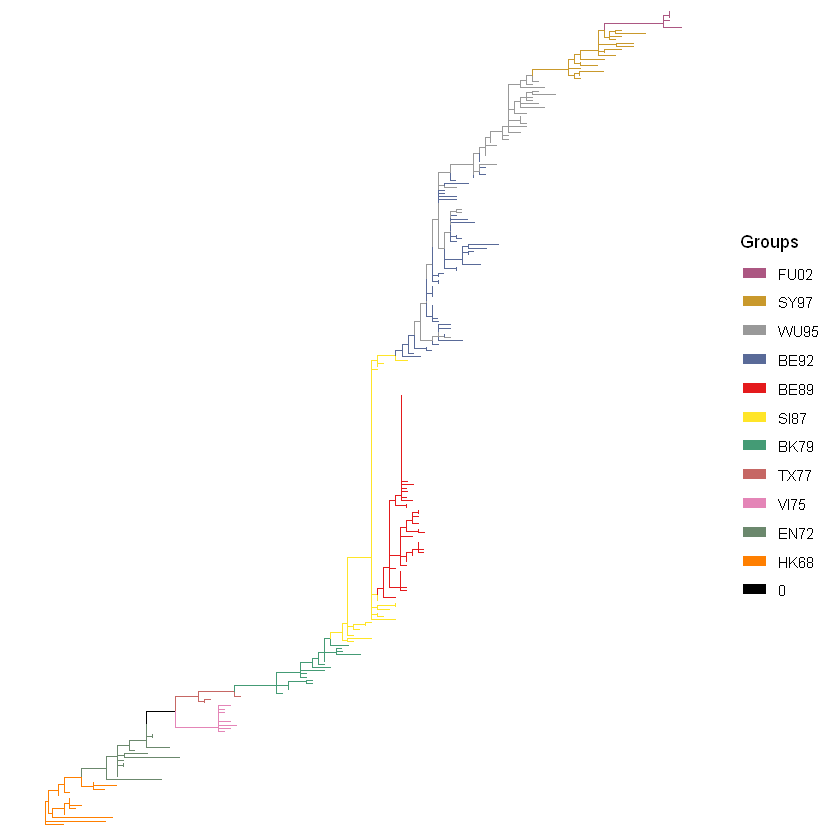

In [4]:
toolname <- "iqtree"

tree <- read.tree(file.path(DATA_DIR, PHYLO_TOOLS[[toolname]]))

tree <- groupOTU(tree, group, group_name = "Groups")
grouplevel <- levels(attr(tree, "Groups"))
grouplevel <- grouplevel[order(sapply(gsub("[^0-9]", "", grouplevel), function(year) {
    if (as.integer(year) > 50) {
        res <- paste0(19, year)
    } else {
        res <- paste0(20, year)
    }
    as.integer(res)
}), decreasing = TRUE)]

attr(tree, "Groups") <- factor(attr(tree, "Groups"), grouplevel)
p <- ggtree(tree, aes(color = Groups)) +
    scale_color_manual(values = as.list(groupColors), limits = grouplevel) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3)
      )
    )
#     theme(legend.position = "left")
p

ggsave(
    filename = file.path(OUTPUT_DIR, paste0("Smith2004_tree_", toolname, ".svg")),
    plot = p,
    width = 6, height = 4
)

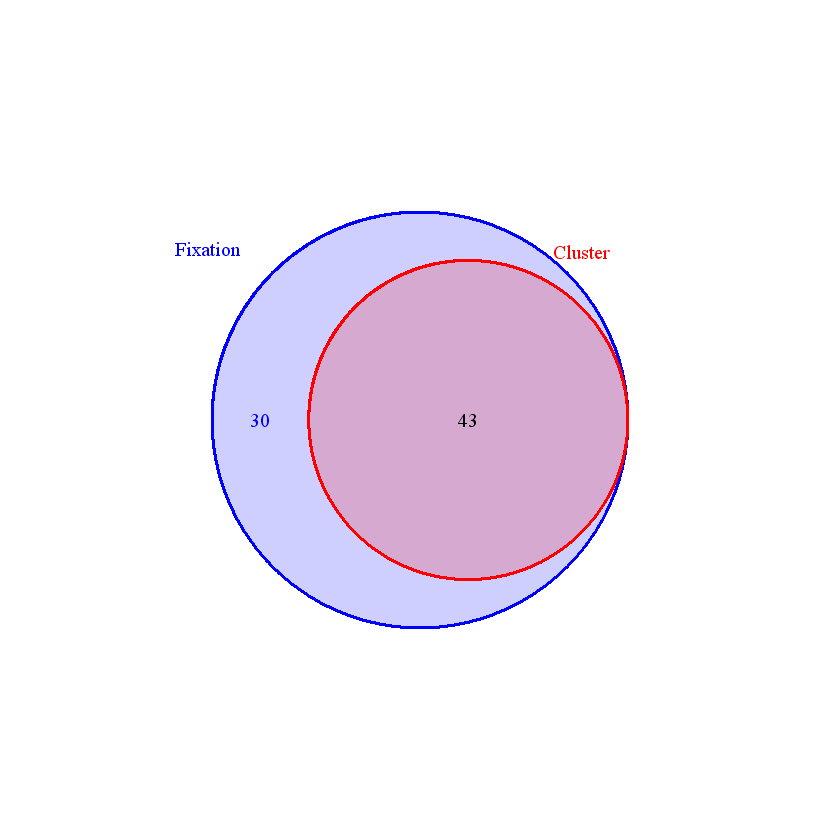

In [5]:
paths <- addMSA(tree, alignment = alignment)
mutations <- fixationSites(paths)

venn.plot <- draw.pairwise.venn(
    area1 = length(mutations),
    area2 = length(ANTIGENIC_SITES),
    cross.area = length(intersect(ANTIGENIC_SITES, as.integer(allSitesName(mutations)))),
    category = c("Fixation", "Cluster"),
    ext.text = FALSE,
    offset = 1,
    fill = c("blue", "red"),
    alpha = c(0.1, 0.1),
    lwd = c(3, 3),
    col = c("blue", "red"),
    label.col = c("blue", "black", "red"),
    cat.col = c("blue", "red"),
    cat.just = list(c(1, -1), c(1, -3)),
    rotation.degree = 180,
    margin = 0.2
)
grid.draw(venn.plot)

svg(filename = file.path(OUTPUT_DIR, "Smith2004_venn.svg"), width = 3, height = 3, bg = "transparent")
grid.draw(venn.plot)
invisible(dev.off())

In [6]:
pdf(file = file.path(OUTPUT_DIR, "TP.pdf"), width = 12, height = 6)
for (site in ANTIGENIC_SITES) {
    p1 <- ggtree(tree, aes(color = Groups)) +
        scale_color_manual(values = as.list(groupColors), limits = grouplevel) +
        theme(legend.position = "left")
    p2 <- plotSingleSite(paths, site, F)
    grid.arrange(arrangeGrob(p1, p2, ncol = 2))
}
invisible(dev.off())

pdf(file = file.path(OUTPUT_DIR, "FP.pdf"), width = 12, height = 6)
for (site in setdiff(as.integer(allSitesName(mutations)), ANTIGENIC_SITES)) {
    p1 <- ggtree(tree, aes(color = Groups)) +
        scale_color_manual(values = as.list(groupColors), limits = grouplevel) +
        theme(legend.position = "left")
    p2 <- plotSingleSite(paths, site, F)
    grid.arrange(arrangeGrob(p1, p2, ncol = 2))
}
invisible(dev.off())

Warning message:
"`filter_()` was deprecated in dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


In [7]:
predResult <- data.frame(
    "Nmin" = integer(),
    "rate" = double(),
    "category" = character()
)
# totalTips <- ape::Ntip(tree)

for (nTip in seq_len(20)[-1]) {
    paths <- lineagePath(paths, nTip)
    mutations <- fixationSites(paths)
    
    assessTable <- siteCategory
    sites <- as.integer(allSitesName(mutations))
    assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
    x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
    senstivity <- length(which(x == 2)) / nPositive
    specificity <- length(which(x == 0)) / nNegative
    predResult <- rbind(
        predResult,
        data.frame(
            "samplingSize" = c(nTip, nTip),
            "rate" = c(senstivity, specificity),
            "category" = c("Senstivity", "Specificity")
        )
    )
}
predResult <- predResult[order(predResult[["samplingSize"]]), ]
row.names(predResult) <- NULL

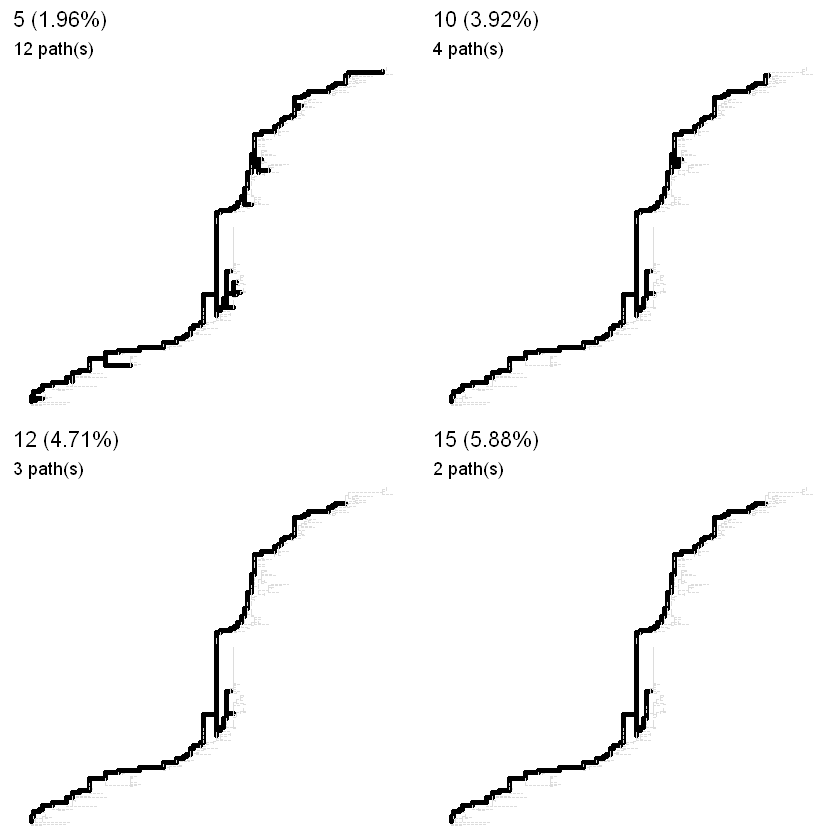

In [8]:
sp <- sneakPeek(paths, makePlot = TRUE)

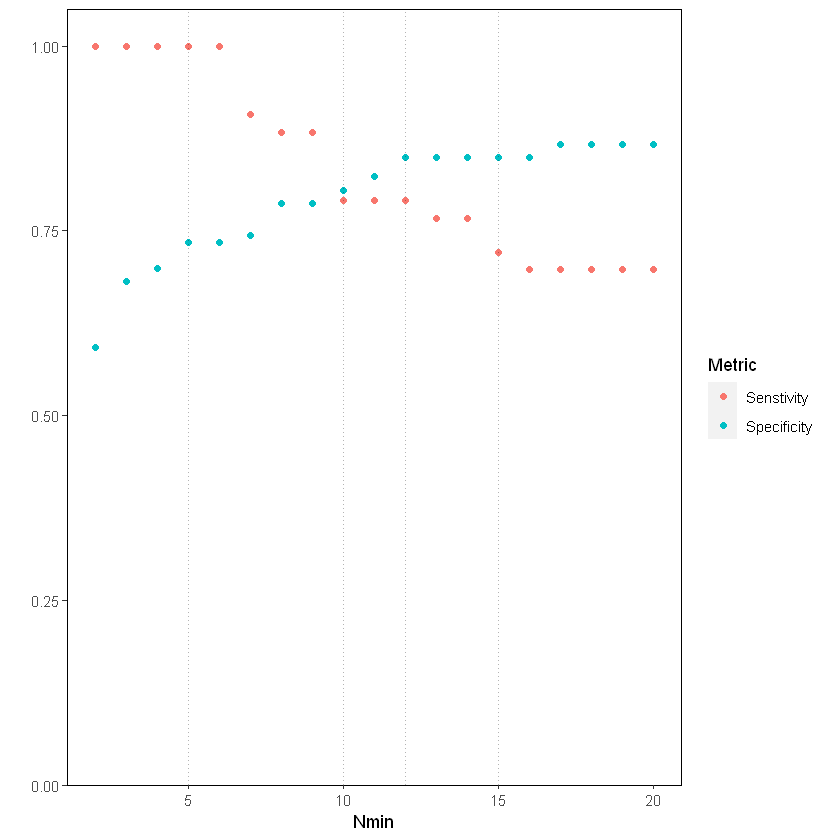

In [9]:
p <- ggplot(predResult, aes(samplingSize, rate)) +
    geom_point(aes(color = category)) + 
    scale_y_continuous(expand = c(0, 0), limits = c(0, 1.05)) +
    labs(x = "Nmin", y = "", color = "Metric") +
    geom_vline(xintercept = c(5, 10, 12, 15), alpha = 0.3, linetype = "dotted") +
    theme(
        panel.background = element_rect(fill = "transparent", color = NA),
        panel.border = element_rect(color = "black", fill = "transparent"),
        panel.grid = element_blank(),         # All grid lines
    )
p

ggsave(
    filename = file.path(OUTPUT_DIR, "samplingSize.svg"),
    plot = p,
    device = "svg",
    width = 3.25, height = 2
)

# 2. Other tools
Run `Data/H3N2_HA1_Smith2004/run_raxml.sh` to build the phylogenetic tree.

In [10]:
predResult2 <- data.frame(
    "software" = integer(),
    "rate" = double(),
    "category" = character()
)

for (toolname in names(PHYLO_TOOLS)) {
    tree <- read.tree(file.path(DATA_DIR, PHYLO_TOOLS[[toolname]]))
    tree <- ape::root(tree, "AF201874.1")
    p <- ggtree(groupOTU(tree, group, group_name = "Groups"), aes(color = Groups)) +
        scale_color_manual(values = as.list(groupColors), limits = names(groupColors))
    ggsave(
        filename = file.path(OUTPUT_DIR, paste0("Smith2004_tree_", toolname, ".svg")),
        plot = p,
        width = 6, height = 4
    )
    paths <- addMSA(tree, alignment = alignment)
    mutations <- fixationSites(paths)
    
    assessTable <- siteCategory
    sites <- as.integer(allSitesName(mutations))
    assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
    x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
    senstivity <- length(which(x == 2)) / nPositive
    specificity <- length(which(x == 0)) / nNegative
    predResult2 <- rbind(
        predResult2,
        data.frame(
            "software" = c(toolname, toolname),
            "rate" = c(senstivity, specificity),
            "category" = c("Senstivity", "Specificity")
        )
    )
}

predResult2$software <- factor(predResult2$software, levels = names(PHYLO_TOOLS))

The "tree" object is not bifurcated and resolved by "multi2di" function.



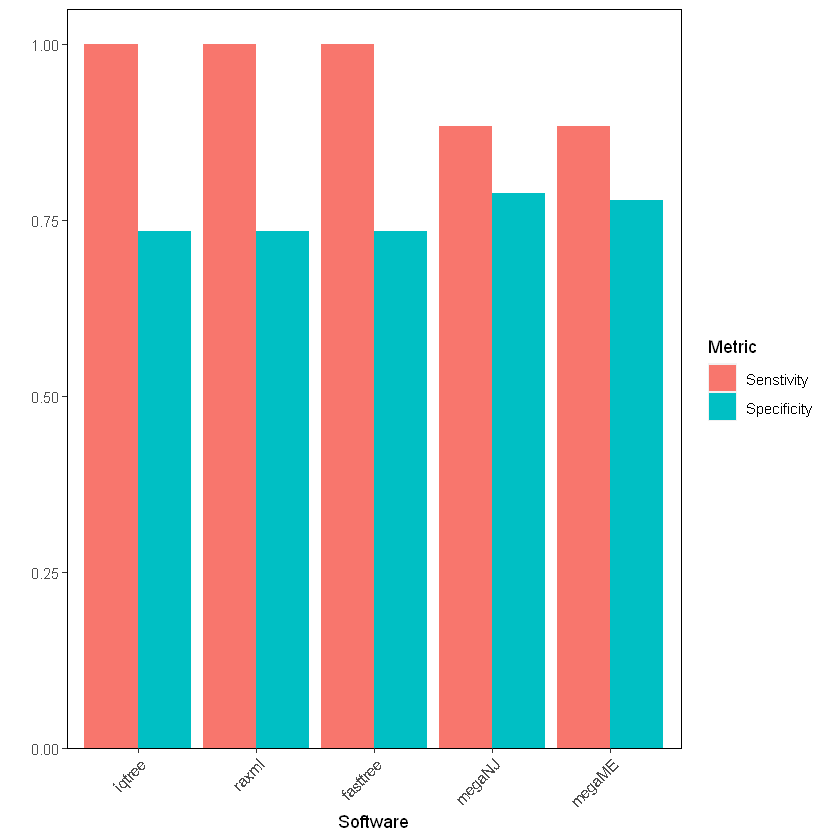

In [11]:
p <- ggplot(predResult2, aes(x = software, y = rate, fill = category)) +
    geom_bar(stat = "identity", position = position_dodge()) +
#     ylim(0, 1) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, 1.05)) +
    labs(x = "Software", y = "", fill = "Metric") +
    theme(
        panel.background = element_rect(fill = "transparent", color = NA),
        panel.border = element_rect(color = "black", fill = "transparent"),
        panel.grid = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1)
    )
    
p

ggsave(
    filename = file.path(OUTPUT_DIR, "software.svg"),
    plot = p,
    device = "svg",
    width = 3.25, height = 2.4
)